# Bfastmonitor CPU using Python
## This is bfastmonitor Python

In [1]:
import os
import wget
import numpy as np
from datetime import datetime

from bfast import BFASTMonitor
from bfast.utils import crop_data_dates

import copy

import matplotlib
import matplotlib.pyplot as plt

#from sar so extra
import csv
from shutil import copyfile
import pandas as pd
from osgeo import gdal

import time
import ipywidgets as widgets

import ipyfilechooser

In [2]:
%matplotlib inline

In [3]:
from os.path import expanduser
path = expanduser("~")

def f(time_series):
    return(time_series)
def g(directory):
    return(directory)

time_series_folder = widgets.interactive(f, 
                        time_series=widgets.Combobox(options=os.listdir(path + "/downloads/"),
                                                     description="Select your time series folder: ",
                                                     style = {'description_width': 'initial'},
                                                     placeholder = "Time_series_..."))
                            
data_directory_name = widgets.interactive(g, 
                        directory=widgets.Text(description="Data storage name:", 
                                               style = {'description_width': 'initial'},
                                               placeholder = "temp"))

display(time_series_folder)
display(data_directory_name)


# how to have the thing wait untill a user fills in the time series

interactive(children=(Combobox(value='', description='Select your time series folder: ', options=('gfc', 'Time…

interactive(children=(Text(value='', description='Data storage name:', placeholder='temp', style=DescriptionSt…

In [5]:
timeseries_directory = time_series_folder.result
data_directory = data_directory_name.result

if not time_series_folder.result:
    raise Exception("No timeseries selected. Please choose a timeseries folder above. ")
else:
    timeseries_directory = path + "/downloads/" + time_series_folder.result + "/1/"
    print("Chosen timeseries: ", timeseries_directory)


if not data_directory_name.result:
    print("Defaulting to data directory name \"temp\" ")
    data_directory = "temp"
else:
    data_directory = data_directory_name.result
    print("Data directory name:", data_directory)


Chosen timeseries:  /home/dven/downloads/Time_series_2020-07-07_11-51-35/1/
Defaulting to data directory name "temp" 


In [6]:
# download and parse input data
ifile_meta = "./data/"+ data_directory + "/dates.txt"
ifile_data = "./data/"+ data_directory + "/data.npy"

# create dirs for stoing the data
if not os.path.isdir("data/" + data_directory):
    os.makedirs("data/" + data_directory)

if not os.path.exists(ifile_meta):
    copyfile(timeseries_directory + "dates.csv", ifile_meta)


In [7]:
# Copy the data over as a npy file 
if not os.path.exists(ifile_data):
    start_time = time.time()
    image_file = os.path.join(timeseries_directory, 'stack.vrt') ## never start os path with a slash
    
    img = gdal.Open(image_file)
    
    cols = img.RasterXSize
    rows = img.RasterYSize
    print(f"Number of  bands: {img.RasterCount}")
    print(f"Number of pixels: {cols}")
    print(f"Number of  lines: {rows}")
    
    # Rewriting NANS to -32668 took 398.04383850097656 seconds for /home/dven/downloads/Time_series_2020-07-06_16-31-46/1/stack.vrt
    raster_stack = img.ReadAsArray()
    print(raster_stack)
#    where_are_nans = np.isnan(raster_stack)
#    raster_stack[where_are_nans] = -32768

    end_time = time.time()


    print("Transferring datatook {} seconds.".format(end_time - start_time))
    
    np.save(ifile_data, raster_stack)

In [8]:
# parameters
k = 3
freq = 365
trend = False
hfrac = 0.25
level = 0.05
start_hist = datetime(2002, 1, 1)
start_monitor = datetime(2012, 1, 1)
end_monitor = datetime(2018, 1, 1)
position = (100,100)

end_monitor

datetime.datetime(2018, 1, 1, 0, 0)

In [9]:
#Fabians code
data_orig = np.load(ifile_data)
with open(ifile_meta) as f:
    dates_list = f.read().split('\n')
    dates = [datetime.strptime(d, '%Y-%m-%d') for d in dates_list if len(d) > 0]


In [10]:
start_date = dates[100] # 0 or 10 does not work.. 100 did
print("startdate",start_date)
end_date = dates[-1]

def h(y):
    return(y)

pandas_dates = pd.date_range(start_date, end_date, freq='D')

options = [(date.strftime(' %d %b %Y '), date) for date in pandas_dates]
index = (0, len(options)-1)


start_end_date = widgets.interactive(h,
                                     y=widgets.SelectionRangeSlider(
                                            options=options,
                                            index=index,
                                            description='Select the monitoring date range: ',
                                            style = {'description_width': 'initial'},
                                            orientation='horizontal',
                                            layout={'width': '800px',"height":"200px"}))
display(start_end_date)

startdate 2004-01-19 00:00:00


interactive(children=(SelectionRangeSlider(description='Select the monitoring date range: ', index=(0, 5984), …

In [18]:
start_monitor, end_monitor = start_end_date.result
print("start monitor: ",start_monitor)
print("end monitor: ",end_monitor)


start monitor:  2012-12-03 00:00:00
end monitor:  2020-06-07 00:00:00


In [19]:
data, dates = crop_data_dates(data_orig, dates, start_hist, end_monitor)
print("First date: {}".format(dates[0]))
print("Last date: {}".format(dates[-1]))
print("Shape of data array: {}".format(data.shape))

# memory errors, work in chunks? 



First date: 2002-01-29 00:00:00
Last date: 2020-06-07 00:00:00
Shape of data array: (473, 8, 14)


In [20]:
# fit BFAST using the CPU implementation (single pixel)
from numpy import nan

start_time = time.time()


model = BFASTMonitor(
            start_monitor,
            freq=freq,
            k=k,
            hfrac=hfrac,
            trend=trend,
            level=level,
            backend='python',
            verbose=1
            )

# only apply on a small subset
data = data[:,:20,:20]
model.fit(data, dates, nan_value=nan) #changed to nan

end_time = time.time()
print("Fitting model took {} seconds.".format(end_time - start_time))


Processing row 0
Processing row 1
Processing row 2
Processing row 3
Processing row 4
Processing row 5
Processing row 6
Processing row 7
Fitting model took 1.2766058444976807 seconds.


In [21]:
# select only negative magnitudes
breaks = model.breaks # index of date that has a break in dates
means = model.means # magnitudes of breaks

no_breaks_indices = (breaks == -1)
means[no_breaks_indices] = 0
means[means > 0] = 0 # only want negative mean changes

breaks_plot = breaks.astype(np.float)
breaks_plot[breaks == -2] = np.nan
breaks_plot[breaks == -1] = np.nan
breaks_plot[means >= 0] = np.nan


In [22]:
dates_monitor = []

# collect dates for monitor period
for i in range(len(dates)):
    if start_monitor <= dates[i]:
        dates_monitor.append(dates[i])
dates_array = np.array(dates_monitor) # dates_array is the dates that are in the monitoring period


In [23]:
idx_starts = {}

# this gives the index of all the data points in the year and after
for year in range(start_monitor.year,end_monitor.year):
    idx_starts[year] = np.argmax((dates_array >= datetime(year, 1, 1)) > False) 
    
print(idx_starts)
breaks_plot_years = copy.deepcopy(breaks_plot)

#classifying for plotting
ticklist=[]
for idx, year in enumerate(idx_starts):
    ticklist.append(str(year))

    if idx == 0:
        breaks_plot_years[breaks_plot <= idx_starts[year+1]] = 0
        continue
    
    if idx == len(idx_starts)-1:
        breaks_plot_years[np.where(idx_starts[year] < breaks_plot)] = len(idx_starts)-1
        continue
        
    breaks_plot_years[np.where(np.logical_and(idx_starts[year] < breaks_plot, breaks_plot <= idx_starts[year+1]))] = idx
print(ticklist)
print(breaks_plot_years)

{2012: 0, 2013: 0, 2014: 29, 2015: 61, 2016: 102, 2017: 143, 2018: 182, 2019: 216}
['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']
[[ 5.  2.  4.  4.  4.  4.  2.  2.  1.  4.  1.  1.  4.  4.]
 [ 4.  1.  4.  4.  6.  4.  7.  7.  3.  4.  3.  3.  3.  4.]
 [ 3.  3.  3.  3. nan  4.  1.  1.  1.  3.  3.  3.  3.  1.]
 [ 4.  3.  3.  3.  4.  2.  2.  2.  2.  2.  2.  2.  3.  1.]
 [ 4.  0.  0.  0.  4.  3.  2.  2.  2.  4.  2.  2.  1.  1.]
 [ 0.  0.  3.  3.  3.  3.  3.  3.  4.  4.  3.  3.  2.  2.]
 [ 0.  4.  4.  4.  3. nan  4.  4.  1.  1.  3.  3.  0.  3.]
 [nan  4.  4.  4.  1. nan  3.  3.  2.  2.  0.  0.  0.  4.]]


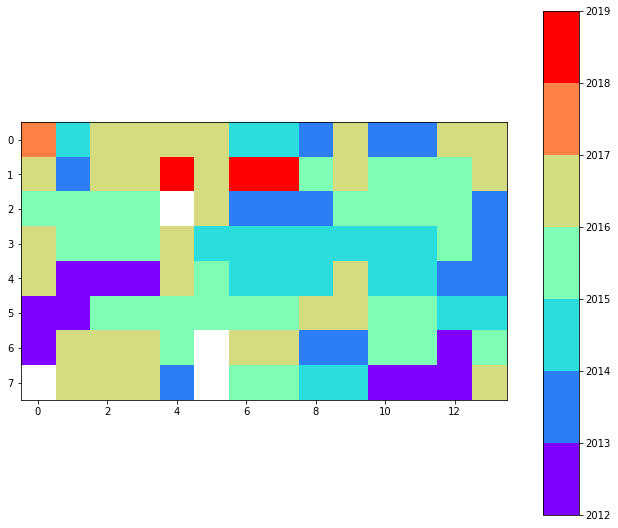

In [24]:
bins = len(idx_starts)

cmap = plt.get_cmap("rainbow")
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

bounds = np.linspace(0, bins-1, bins) #third number is the amount of bins in the colorbar 0=0, 6 = ncolors, 7= nyears
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
im = axes.imshow(breaks_plot_years, cmap=cmap, vmin=0, vmax=bins, norm=norm)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, ticks=range(bins))
labels = cbar_ax.set_yticklabels(ticklist)

plt.savefig("./picture.png")
plt.show()


In [ ]:
# idx_start_2010 = np.argmax((dates_array >= datetime(2010, 1, 1)) > False) 
# idx_start_2011 = np.argmax((dates_array >= datetime(2011, 1, 1)) > False) # count how many dates do not come after 2011
# idx_start_2012 = np.argmax((dates_array >= datetime(2012, 1, 1)) > False) # this gives the index of the date starting in 
# idx_start_2013 = np.argmax((dates_array >= datetime(2013, 1, 1)) > False) # the respective year
# idx_start_2014 = np.argmax((dates_array >= datetime(2014, 1, 1)) > False)
# idx_start_2015 = np.argmax((dates_array >= datetime(2015, 1, 1)) > False)
# idx_start_2016 = np.argmax((dates_array >= datetime(2016, 1, 1)) > False)

# breaks_plot_years = copy.deepcopy(breaks_plot)
# breaks_plot_years[breaks_plot <= idx_start_2011] = 0
# breaks_plot_years[np.where(np.logical_and(idx_start_2011 < breaks_plot, breaks_plot <= idx_start_2012))] = 1
# breaks_plot_years[np.where(np.logical_and(idx_start_2012 < breaks_plot, breaks_plot <= idx_start_2013))] = 2
# breaks_plot_years[np.where(np.logical_and(idx_start_2013 < breaks_plot, breaks_plot <= idx_start_2014))] = 3
# breaks_plot_years[np.where(np.logical_and(idx_start_2014 < breaks_plot, breaks_plot <= idx_start_2015))] = 4
# breaks_plot_years[np.where(np.logical_and(idx_start_2015 < breaks_plot, breaks_plot <= idx_start_2016))] = 5
# breaks_plot_years[np.where(idx_start_2016 < breaks_plot)] = 6
# print(breaks_plot_years)

# cmap = plt.get_cmap("rainbow")
# cmaplist = [cmap(i) for i in range(cmap.N)]
# cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

# bounds = np.linspace(0, 6, 7) #third number is the amount of bins in the colorbar 0=0, 6 = ncolors, 7= nyears
# norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

# fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
# im = axes.imshow(breaks_plot_years, cmap=cmap, vmin=0, vmax=6, norm=norm)
# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
# fig.colorbar(im, cax=cbar_ax, ticks=[0, 1, 2, 3, 4, 5, 6])
# labels = cbar_ax.set_yticklabels(['2010', '2011', '2012', '2013', '2014', '2015', '2016'])

# plt.savefig("./picture.png")
# plt.show()


In [ ]:
#big
# ts_dir = "downloads/Time_series_2020-07-06_16-31-46/"
# country_dir = "temp"
# download_dir = "1/"

#ts_dir = "downloads/Time_series_2020-07-07_11-51-35/"
#country_dir = "portugal_small"
#download_dir = "1/"

#os.listdir(path + "/downloads/")
#widgets.interact(f, time_series=widgets.Combobox(options=os.listdir(path + "/downloads/")));

# def f(widget_start_monitor,widget_end_monitor):
#     return widget_start_monitor, widget_end_monitor

# #widgets.interact(f, widget_start_monitor=widgets.Combobox(options=dates_list, value=dates_list[1]));



# layout = widgets.Layout(width='500px', height='100px') #set width and height


# def print_date_range(date_range):
#     return(date_range)

# start_end_date = widgets.interactive(print_date_range,
#     date_range=widgets.SelectionRangeSlider(options = dates_list, 
#                              max = dates_list[-3],
#                              description="Monitoring Period",
#                              style = {'description_width': 'initial'},
#                              display="flex",
#                              align_items="stretch",
#                              layout = layout))

# display(start_end_date)



             